In [7]:
import geopandas
import pandas as pd
from osgeo import ogr,gdal
import os,sys
import numpy 
from tqdm import tqdm
from shapely.wkb import loads
import pygeos
import matplotlib.pyplot as plt
import openpyxl
import re
import pygeos
import geopandas as gpd
from rasterstats import zonal_stats
import pyproj
from tqdm import tqdm
from pathlib import Path

from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [8]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 


def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    pygeos_geo = pygeos.from_wkt(feature.geometry().ExportToWkt())
                    if pygeos_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(pygeos_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}

def landuse(osm_path):
    """
    Function to extract land-use polygons from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.    
    """    
    return(retrieve(osm_path,'multipolygons',['landuse']))

def buildings(osm_path):
    """
    Function to extract building polygons from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique building polygons.    
    """
    return retrieve(osm_path, 'multipolygons',['building','amenity'])

def roads(osm_path):
    """
    Function to extract road linestrings from OpenStreetMap  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique road linestrings.
    """   
    return retrieve(osm_path,'lines',['highway']) 
 
#def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    #return retrieve(osm_path,'lines',['railway','service'],**{"service":[" IS NOT NULL"]})

def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])

def train_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['railway'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['man_made'],**{'man_made':["='communications_tower'"]})).rename(columns={'man_made': 'asset'})

def subway_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='subway_entrance'"]}))     # useless

def tram_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='tram_stop'"]}))

def ferries(osm_path):
    """
    Function to extract road linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique road linestrings.
    """
    return retrieve(osm_path,'lines',['route'],**{"route":["='ferry'",]})

def electricity(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.   
    """    
    return retrieve(osm_path,'lines',['power','voltage']) #,**{'voltage':[" IS NULL"],}

def mainRoads(osm_path):
    """
    Function to extract main road linestrings from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique main road linestrings.   
    """ 
    return retrieve(osm_path,'lines',['highway','oneway','lanes','maxspeed'],**{'highway':["='primary' or ","='trunk' or ","='motorway' or ","='trunk_link' or ",
                    "='primary_link' or ", "='secondary' or ","='tertiary' or ","='tertiary_link'"]})


def remove_overlap_openstreetmap(gdf):
    """
    Function to remove overlap in polygons in from OpenStreetMap.
    
    Arguments:
        *gdf* : a geopandas GeoDataFrame with all unique railway linestrings.
        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with (almost) non-overlapping polygons.
    
    """
    
    gdf['sq_area'] = gdf.area

    new_landuse = []
    for use in tqdm(gdf.itertuples(index=False),total=len(gdf),desc='Get unique shapes'):
        use_geom = use.geometry
        matches = gdf.loc[list(gdf.sindex.intersection(use.geometry.bounds))]
        for match in matches.itertuples(index=False):
            if use.sq_area > match.sq_area:
                use_geom = use_geom.difference(match.geometry)
        new_landuse.append([use.osm_id,use.landuse,use_geom])

    new_gdf  =  geopandas.GeoDataFrame(pandas.DataFrame(new_landuse,columns=['osm_id','landuse','geometry'])) 
    new_gdf.crs = {'init' : 'epsg:4326'}
    return new_gdf


def extract_value_other_gdf(x,gdf,col_name):
    """
    Function to extract value from column from other GeoDataFrame
    
    Arguments:
        *x* : row of main GeoDataFrame.
        
        *gdf* : geopandas GeoDataFrame from which we want to extract values.
        
        *col_name* : the column name from which we want to get the value.
        
    
    """
    try:
        return gdf.loc[list(gdf.sindex.intersection(x.geometry.bounds))][col_name].values[0]
    except:
        return None

def get_losses(x,damage_curves,damage_values):
    """
    Function to estimate the damages.
    
    Arguments:
        *x* : row of main GeoDataFrame
        
        *damage_curves*: pandas DataFrame of curves. Inundation depths should be the index.
        
        *damage_values*: dictionary with maximum damage values.
        
    Returns:
        
        Total damage for the given land-use object.
    
    """
    
    return numpy.interp(x.depth,list(damage_curves.index),list(damage_curves[x.landuse]))*damage_values[x.landuse]*x.area_m2

In [9]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

<AxesSubplot: >

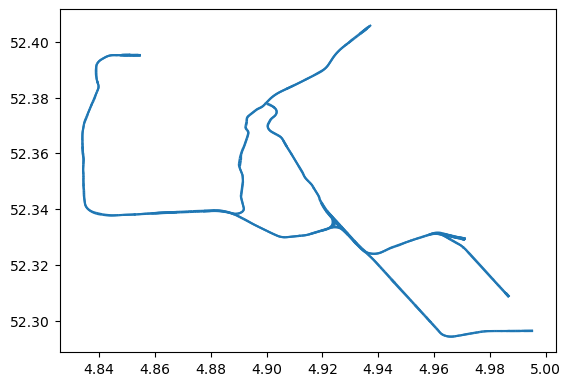

In [10]:
df_railway = railway(osm_data)
subway = df_railway.loc[df_railway.railway == 'subway']
subway.plot()

In [11]:
df_subway = pd.DataFrame(subway.copy())
df_subway.geometry = pygeos.from_shapely(df_subway.geometry)

In [12]:
# create mini simplified network and graph of network
net = Network(edges=df_subway)

# add nodes to the network
net = add_endpoints(net)

# split edges at new nodes
net = split_edges_at_nodes(net)

# readd or remove points based on split
net = add_endpoints(net)

# give nodes and edges an id
net = add_ids(net)

# add topology (Geometry) if still missing
net = add_topology(net)    

# add degree
net.nodes['degree'] = calculate_degree(net)

# merge edges with degree two
net = merge_edges(net)

# remove duplicate edges
net.edges = drop_duplicate_geometries(net.edges, keep='first') 

# reset ids based on previous fixes
net = reset_ids(net) 

net = add_distances(net)
net = merge_multilinestrings(net)
net = add_travel_time(net)  

topology: 100%|████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 8988.50it/s]


In [13]:
edges, nodes = net.edges,net.nodes

In [14]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time
0,23157994,"LINESTRING (4.922 52.338, 4.922 52.338, 4.923 ...",subway,NaN,0,294,20,858.377718,0.042919
1,23189033,"LINESTRING (4.846 52.395, 4.847 52.395, 4.847 ...",subway,NaN,1,115,120,237.962864,0.011898
2,23189039,"LINESTRING (4.839 52.386, 4.839 52.386, 4.839 ...",subway,NaN,2,200,115,1320.099057,0.066005
3,23189059,"LINESTRING (4.837 52.377, 4.837 52.378, 4.837 ...",subway,NaN,3,172,201,902.754616,0.045138
4,23189063,"LINESTRING (4.839 52.385, 4.84 52.385, 4.84 52...",subway,NaN,4,191,173,850.965721,0.042548
...,...,...,...,...,...,...,...,...,...
387,1061085945,"LINESTRING (4.922 52.339, 4.922 52.338, 4.922 ...",subway,NaN,387,198,294,34.811758,0.001741
388,1131538376,"LINESTRING (4.921 52.339, 4.921 52.34, 4.921 5...",subway,NaN,388,64,58,348.667904,0.017433
389,1131538382,"LINESTRING (4.922 52.339, 4.921 52.34, 4.921 5...",subway,NaN,389,97,98,350.467868,0.017523
390,1131538383,"LINESTRING (4.92 52.342, 4.92 52.342, 4.92 52....",subway,NaN,390,98,136,307.079253,0.015354


In [15]:
edges.to_excel('./edges.xlsx',header = True, index = False)

In [16]:
nodes

,geometry,degree,id
0,POINT (4.853 52.338),3,0
1,POINT (4.958 52.331),3,1
2,POINT (4.987 52.309),1,2
3,POINT (4.97 52.33),4,3
4,POINT (4.97 52.329),3,4
...,...,...,...
292,POINT (4.852 52.395),3,292
293,POINT (4.855 52.395),1,293
294,POINT (4.922 52.338),3,294
295,POINT (4.922 52.338),3,295


<AxesSubplot: >

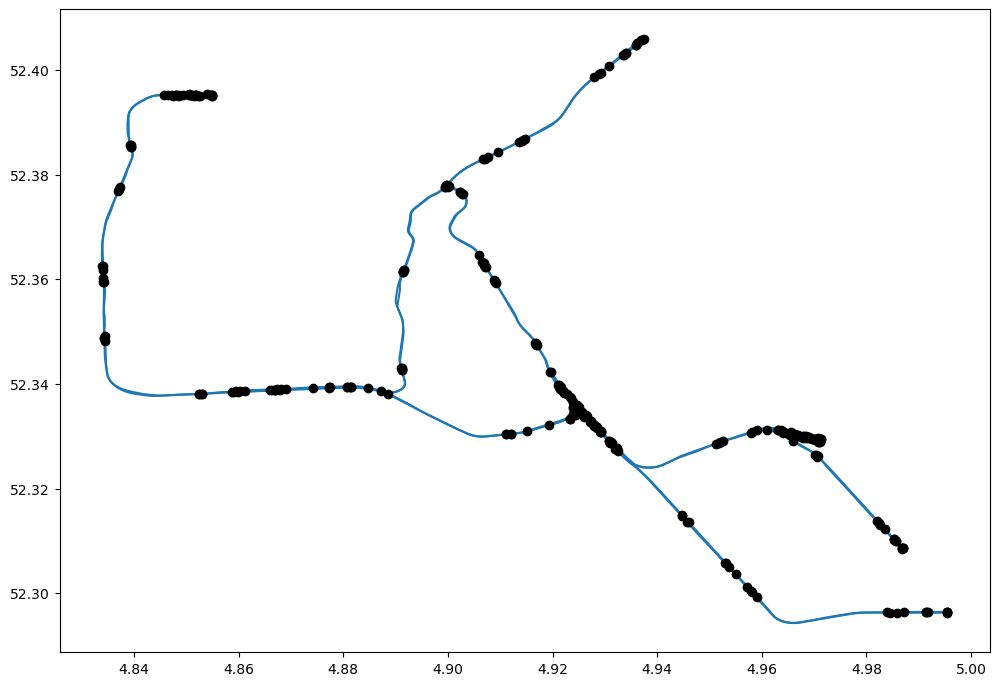

In [17]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(nodes.copy()).plot(ax=ax,color='black',zorder=1)

In [18]:
gpd.GeoDataFrame(edges.copy()).to_file('edges_metro_amsterdam.gpkg',driver='GPKG')
gpd.GeoDataFrame(nodes.copy()).to_file('nodes_metro_amsterdam.gpkg',driver='GPKG')

In [19]:
edges['weights'] = edges['distance'].astype(int)

In [20]:
od = edges[['from_id', 'to_id', 'weights']]
od

,from_id,to_id,weights
0,294,20,858
1,115,120,237
2,200,115,1320
3,172,201,902
4,191,173,850
...,...,...,...
387,198,294,34
388,64,58,348
389,97,98,350
390,98,136,307


In [32]:
import itertools
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b) 

In [60]:
edges['to_from'] = list(zip(edges.from_id,edges.to_id))
edges['from_to'] = list(zip(edges.to_id,edges.from_id))

In [64]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,23157994,"LINESTRING (4.922 52.338, 4.922 52.338, 4.923 ...",subway,NaN,0,294,20,858.377718,0.042919,858,"(294, 20)","(20, 294)"
1,23189033,"LINESTRING (4.846 52.395, 4.847 52.395, 4.847 ...",subway,NaN,1,115,120,237.962864,0.011898,237,"(115, 120)","(120, 115)"
2,23189039,"LINESTRING (4.839 52.386, 4.839 52.386, 4.839 ...",subway,NaN,2,200,115,1320.099057,0.066005,1320,"(200, 115)","(115, 200)"
3,23189059,"LINESTRING (4.837 52.377, 4.837 52.378, 4.837 ...",subway,NaN,3,172,201,902.754616,0.045138,902,"(172, 201)","(201, 172)"
4,23189063,"LINESTRING (4.839 52.385, 4.84 52.385, 4.84 52...",subway,NaN,4,191,173,850.965721,0.042548,850,"(191, 173)","(173, 191)"
...,...,...,...,...,...,...,...,...,...,...,...,...
387,1061085945,"LINESTRING (4.922 52.339, 4.922 52.338, 4.922 ...",subway,NaN,387,198,294,34.811758,0.001741,34,"(198, 294)","(294, 198)"
388,1131538376,"LINESTRING (4.921 52.339, 4.921 52.34, 4.921 5...",subway,NaN,388,64,58,348.667904,0.017433,348,"(64, 58)","(58, 64)"
389,1131538382,"LINESTRING (4.922 52.339, 4.921 52.34, 4.921 5...",subway,NaN,389,97,98,350.467868,0.017523,350,"(97, 98)","(98, 97)"
390,1131538383,"LINESTRING (4.92 52.342, 4.92 52.342, 4.92 52....",subway,NaN,390,98,136,307.079253,0.015354,307,"(98, 136)","(136, 98)"


# Shortest path test1

In [21]:
import networkx as nx

In [22]:
nodes_list = nodes.iloc[:,2].tolist()
#nodes_list

In [66]:
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)

In [24]:
#edges_list = [tuple(x) for x in od.values]
#edges_list

In [25]:
G = nx.Graph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

In [ ]:
#p20 = nx.shortest_path(G, source = 20, weight = "weight")
#print("All shortest path from 20: ", p20)

##### 1.next step 1 如何把这一块选路线改成自动化的？？？？   输入你想知道的线路得到路线图 √
##### 2.next step 2 怎么在绘出的图上标注出路线起点终点？？？？
##### 3.nest thinking怎么自动实现某条线路丢失后的最短路？？？

In [90]:
s = int(input("enter the id of start node: "))
e = int(input("enter the id of end node: "))

enter the id of start node:  20
enter the id of end node:  6


In [91]:
path_s_e = nx.shortest_path(G, source = s, target = e, weight = "weight")
print(f"Shortest path from {s} to {e}: ", path_s_e)

Shortest path from 20 to 6:  [20, 21, 144, 137, 138, 50, 46, 133, 129, 42, 71, 8, 7, 6]


In [92]:
length_s_e = nx.shortest_path_length(G, source = s, target = e, weight = "weight")
print(f"Length of the shortest path from {s} to {e}: ", length_s_e)

Length of the shortest path from 20 to 6:  4156


In [94]:
short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]    

In [95]:
short_path_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
21,24343641,"LINESTRING (4.963 52.331, 4.963 52.331, 4.963 ...",subway,yard,21,6,7,199.144869,0.009957,199,"(6, 7)","(7, 6)"
27,24343655,"LINESTRING (4.966 52.33, 4.965 52.33, 4.965 52...",subway,yard,27,7,8,108.240427,0.005412,108,"(7, 8)","(8, 7)"
53,27934485,"LINESTRING (4.919 52.332, 4.92 52.332, 4.92 52...",subway,NaN,53,20,21,715.952973,0.035798,715,"(20, 21)","(21, 20)"
80,160502614,"LINESTRING (4.958 52.331, 4.957 52.33, 4.957 5...",subway,NaN,80,42,129,461.262361,0.023063,461,"(42, 129)","(129, 42)"
81,160502778,"LINESTRING (4.952 52.329, 4.952 52.329, 4.952 ...",subway,NaN,81,129,133,24.797897,0.001240,24,"(129, 133)","(133, 129)"
103,166130762,"LINESTRING (4.929 52.331, 4.93 52.33, 4.931 52...",subway,NaN,103,144,137,220.637762,0.011032,220,"(144, 137)","(137, 144)"
107,166130769,"LINESTRING (4.932 52.328, 4.932 52.328, 4.932 ...",subway,None,107,46,50,140.406954,0.007020,140,"(46, 50)","(50, 46)"
157,176555192,"LINESTRING (4.964 52.331, 4.964 52.331, 4.964 ...",subway,yard,157,8,71,366.043969,0.018302,366,"(8, 71)","(71, 8)"
158,178852876,"LINESTRING (4.952 52.329, 4.951 52.329, 4.951 ...",subway,NaN,158,133,46,1676.075040,0.083804,1676,"(133, 46)","(46, 133)"
230,394944444,"LINESTRING (4.931 52.329, 4.931 52.329, 4.931 ...",subway,None,230,137,138,37.706089,0.001885,37,"(137, 138)","(138, 137)"


<AxesSubplot: >

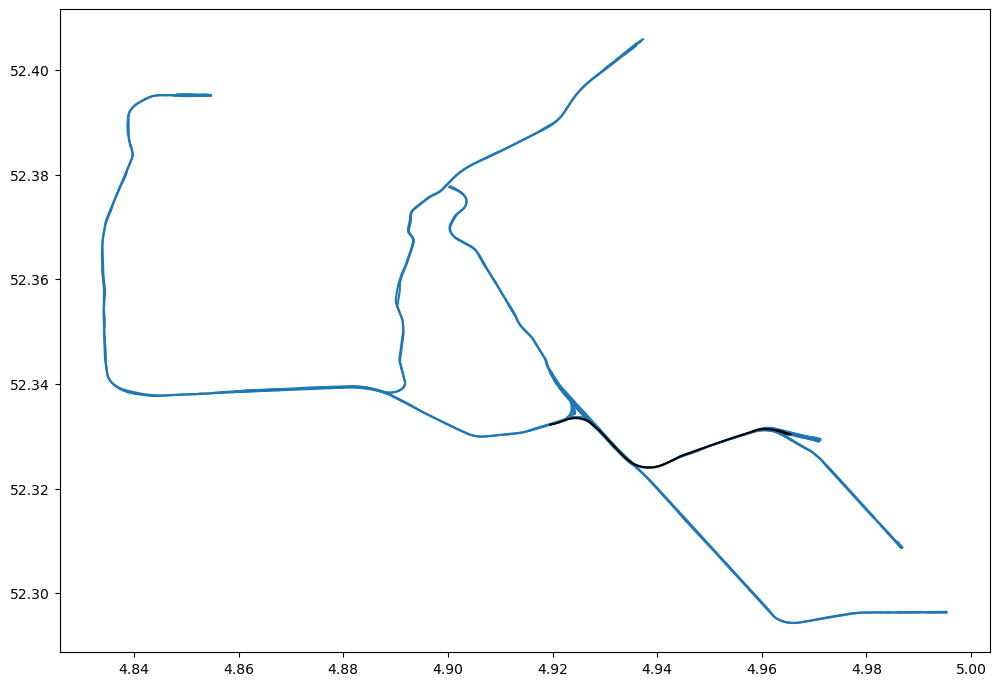

In [96]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(short_path_edges.copy()).plot(ax=ax,color='black',zorder=1)#, linewidth = short_path_edges.weithts)

<AxesSubplot: >

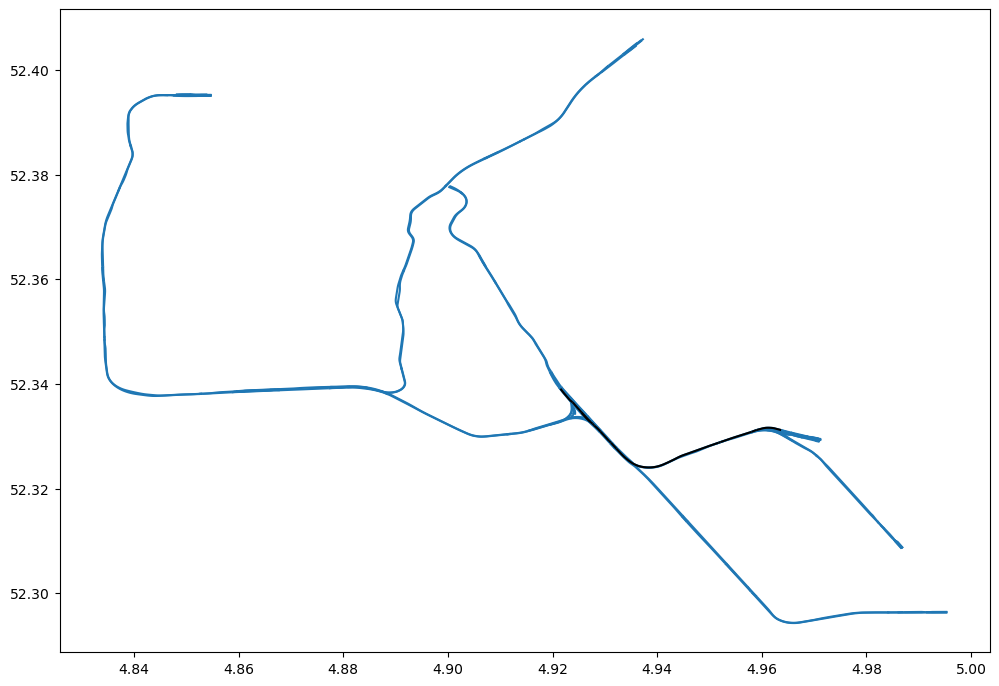

In [88]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(short_path_edges.copy()).plot(ax=ax,color='black',zorder=1)#, linewidth = short_path_edges.weithts)

##### functions need to learn：
##### plot.()\.GeoDataFrame（）\df.loc[]\zip(a,b)\itertool
##### Questions：
##### 1.why it can draw according to the coordinates?   
##### 2.what is zorder_**style_kwdsdict????Style options to be passed on to the actual plot function, such as edgecolor, facecolor, linewidth, markersize, alpha.
##### 3.why use df.copy()????

# Get route and length of one shortest path  
(get answers with NaN because of overlooking the question of directions __ *edges* without directions, *p20to6* have one-way direction)

In [ ]:
p20to6 = nx.shortest_path(G, source = 20, target = 6, weight = "weight")
length20to6 = nx.shortest_path_length(G, source = 20, target = 6, weight = "weight")
print("Shortest path from 20 to 6: ", p20to6)
print("Length of the shortest path from 20 to 6: ", length20to6)

In [ ]:
p20to6_fromid = p20to6
p20to6_toid = p20to6_fromid[1:]
p20to6_idlist = [[p20to6_fromid[i], p20to6_toid[i]] for i in range(len(p20to6_toid))]
p20to6_idlist

In [50]:
p20to6id_path = pd.DataFrame(p20to6_idlist, columns = ['from_id', 'to_id'])
#print(p20to6id_path)
p20to6id_edge = pd.merge(p20to6id_path, edges[['id', 'from_id', 'to_id', 'weights']], on = ['from_id', 'to_id'], how = 'left')
p20to6id_edge

,from_id,to_id,id,weights
0,20,21,53.0,715.0
1,21,144,234.0,118.0
2,144,137,103.0,220.0
3,137,138,230.0,37.0
4,138,50,NaN,NaN
5,50,46,NaN,NaN
6,46,133,NaN,NaN
7,133,129,NaN,NaN
8,129,42,NaN,NaN
9,42,71,NaN,NaN


In [22]:
p1to6 = nx.shortest_path(G, source = 1, target = 6, weight = "weight")
length1to6 = nx.shortest_path_length(G, source = 1, target = 6, weight = "weight")
print("Shortest path from 1 to 6: ", p1to6)
print("Length of the shortest path from 1 to 6: ", length1to6)

Shortest path from 1 to 6:  [1, 72, 161, 287, 83, 5, 74, 10, 7, 6]
Length of the shortest path from 1 to 6:  928


In [43]:
p1to6_fromid = p1to6
p1to6_toid = p1to6_fromid[1:]
p1to6_idlist = [[p1to6_fromid[i], p1to6_toid[i]] for i in range(len(p1to6_toid))]
p1to6_idlist

[[1, 72],
 [72, 161],
 [161, 287],
 [287, 83],
 [83, 5],
 [5, 74],
 [74, 10],
 [10, 7],
 [7, 6]]

In [46]:
p1to6id_path = pd.DataFrame(p1to6_idlist, columns = ['from_id', 'to_id'])
print(p1to6id_path)

   from_id  to_id
0        1     72
1       72    161
2      161    287
3      287     83
4       83      5
5        5     74
6       74     10
7       10      7
8        7      6


In [47]:
p1to6id_edge = pd.merge(p1to6id_path, edges[['id', 'from_id', 'to_id', 'weights']], on = ['from_id', 'to_id'], how = 'left')
p1to6id_edge

,from_id,to_id,id,weights
0,1,72,161.0,224.0
1,72,161,162.0,319.0
2,161,287,163.0,19.0
3,287,83,164.0,19.0
4,83,5,165.0,29.0
5,5,74,166.0,32.0
6,74,10,NaN,NaN
7,10,7,NaN,NaN
8,7,6,NaN,NaN


# Strive data from OSM to excel

In [ ]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

In [ ]:
train_stations(osm_data)  

In [ ]:
df_trainsta = train_stations(osm_data)

In [ ]:
df_trainsta.plot() # why it draw a graph according to the coordinates?

In [ ]:
df_trainsta.to_excel('./train_stations.xlsx',header = True, index = False,sheet_name = 'mydata')        # subway station nodes

In [ ]:
railway(osm_data)

In [ ]:
df_railway = railway(osm_data)

In [ ]:
subway = df_railway.loc[df_railway.railway == 'subway']
subway.plot()

In [ ]:
subway.to_excel('./subway.xlsx',header = True, index = False,sheet_name = 'mydata')          # subway edges

# Creat amsterdam subway manually with NetworkX 

In [ ]:
# Try to draw the nodes and lines together and get od pairs      Didn't work, try another way with module —— simplify
'''df1 = pd.read_excel(r'./subway1.xlsx','sheet1')
df2 = pd.read_excel(r'./subway2.xlsx','sheet1')
frames = [df1,df2]
df = pd.concat(frames)
df.to_excel('./subwayall.xlsx',header = True, index = False)
df.plot()   '''

In [ ]:
import networkx as nx

In [ ]:
df = pd.read_excel(r'./amsub.xlsx','od_net_undirected')

In [ ]:
G = nx.from_pandas_edgelist(df, 'origin', 'destination', create_using = nx.Graph()) # unweighted

In [ ]:
nx.draw(G, node_size = 500, node_color = 'yellow', with_labels = True)

In [ ]:
WG = nx.from_pandas_edgelist(df, 'origin', 'destination','weight', create_using = nx.Graph()) # weighted - random running time as weight 

In [ ]:
edge_width = nx.get_edge_attributes(WG, "weight")
nx.draw(WG, node_size = 500, node_color = 'pink', with_labels = True, width = list(edge_width.values()))

##### 1.retrive *name* together with *osm_id* *railway* *geometry*   √ 
##### 2.automatically get OD pair (by drawing nodes and edges together)    how? —— using simplify module √
##### 3.*train_stations(osm_data)* contains subway stations and railway stations， need to seperate them and get the unretrived station有时候因为站点是线条或区域格式而提取不到  —— don't need to do it now with the simplify module    √
##### 4.how to draw different routes